# Objektklassifizierung mit APOC und SimpleITK-basierten Merkmalen

Die Klassifizierung von Objekten kann die Extraktion benutzerdefinierter Merkmale beinhalten. Wir simulieren dieses Szenario, indem wir [SimpleITK-basierte](https://simpleitk.readthedocs.io/) Merkmale verwenden, die in [napari-simpleitk-image-processing](https://www.napari-hub.org/plugins/napari-simpleitk-image-processing) verfügbar sind, und trainieren einen APOC [table-row-classifier](https://nbviewer.org/github/haesleinhuepf/apoc/blob/main/demo/table_row_classification.ipynb).

Siehe auch
* [Maschinelles Lernen für Pixel- und Objektklassifizierung (Videovorlesung)](https://www.youtube.com/watch?v=dstjhCPBDOY&list=PL5ESQNfM5lc7SAMstEu082ivW4BDMvd0U&index=19)

In [1]:
from skimage.io import imread
from pyclesperanto_prototype import imshow, replace_intensities
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from napari_simpleitk_image_processing import label_statistics
import apoc

Unser Ausgangspunkt sind ein Bild, ein Labelbild und einige Ground-Truth-Annotationen. Die Annotation ist ebenfalls ein Labelbild, bei dem der Benutzer einfach Linien mit unterschiedlicher Intensität (Klasse) durch kleine Objekte, große Objekte und längliche Objekte gezeichnet hat.

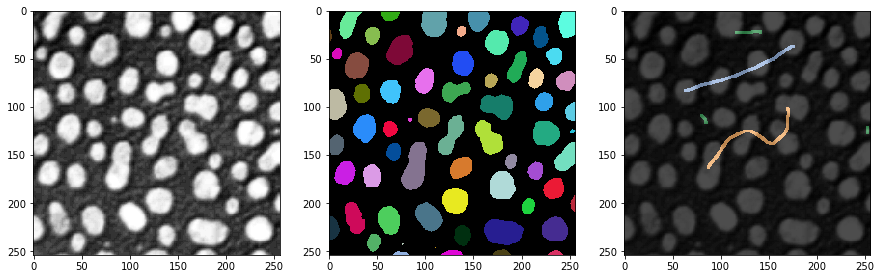

In [2]:
# load and label data
image = imread('../../data/blobs.tif')
labels = label(image > threshold_otsu(image))
annotation = imread('../../data/label_annotation.tif')

# visualize
fig, ax = plt.subplots(1,3, figsize=(15,15))
imshow(image, plot=ax[0])
imshow(labels, plot=ax[1], labels=True)
imshow(image, plot=ax[2], continue_drawing=True)
imshow(annotation, plot=ax[2], alpha=0.7, labels=True)

## Merkmalsextraktion
Der erste Schritt zur Klassifizierung von Objekten nach ihren Eigenschaften ist die [Merkmalsextraktion](feature_extraction). Wir werden dafür das skriptfähige napari-Plugin [napari-simpleitk-image-processing](https://www.napari-hub.org/plugins/napari-simpleitk-image-processing) verwenden.

In [3]:
statistics = label_statistics(image, labels, None, True, True, True, True, True, True)

statistics_table = pd.DataFrame(statistics)
statistics_table

label  maximum        mean  median  minimum      sigma       sum  \
0       1    232.0  190.854503   200.0    128.0  30.304925   82640.0   
1       2    224.0  179.286486   184.0    128.0  21.883314   33168.0   
2       3    248.0  205.617021   208.0    128.0  29.380812  135296.0   
3       4    248.0  217.327189   232.0    128.0  36.061134   94320.0   
4       5    248.0  212.142558   224.0    128.0  29.904270  101192.0   
..    ...      ...         ...     ...      ...        ...       ...   
59     60    128.0  128.000000   128.0    128.0   0.000000     128.0   
60     61    248.0  183.407407   176.0    128.0  34.682048   14856.0   
61     62    216.0  181.511111   184.0    128.0  25.599001   16336.0   
62     63    248.0  188.377358   184.0    128.0  38.799398    9984.0   
63     64    224.0  172.897959   176.0    128.0  28.743293    8472.0   

       variance  bbox_0  bbox_1  ...  number_of_pixels_on_border  perimeter  \
0    918.388504      10       0  ...                          17  89.196525   
1    478.879436      53       0  ...                          21  53.456120   
2    863.232099      95       0  ...                          23  93.409370   
3   1300.405402     144       0  ...                          19  75.558902   
4    894.265349     237       0  ...                          39  82.127941   
..          ...     ...     ...  ...                         ...        ...   
59     0.000000     110     246  ...                           0   2.681517   
60  1202.844444     170     248  ...                          19  41.294008   
61   655.308864     116     249  ...                          23  48.093086   
62  1505.393324     227     249  ...                          16  34.264893   
63   826.176871      66     250  ...                          17  35.375614   

    perimeter_on_border  perimeter_on_border_ratio  principal_axes0  \
0                  17.0                   0.190590         0.902586   
1                  21.0                   0.392846        -0.051890   
2                  23.0                   0.246228         0.988608   
3                  19.0                   0.251459         0.870813   
4                  40.0                   0.487045         0.998987   
..                  ...                        ...              ...   
59                  0.0                   0.000000         1.000000   
60                 19.0                   0.460115        -0.005203   
61                 23.0                   0.478239        -0.023708   
62                 16.0                   0.466950         0.004852   
63                 17.0                   0.480557         0.022491   

    principal_axes1  principal_axes2  principal_axes3  principal_moments0  \
0          0.430509        -0.430509         0.902586           17.680049   
1         -0.998653         0.998653        -0.051890            8.708186   
2          0.150515        -0.150515         0.988608           49.978765   
3          0.491615        -0.491615         0.870813           33.246984   
4          0.045005        -0.045005         0.998987           24.584386   
..              ...              ...              ...                 ...   
59         0.000000         0.000000         1.000000            0.000000   
60        -0.999986         0.999986        -0.005203            2.190911   
61        -0.999719         0.999719        -0.023708            1.801689   
62        -0.999988         0.999988         0.004852            1.603845   
63        -0.999747         0.999747         0.022491            0.923304   

    principal_moments1  
0            76.376232  
1            27.723954  
2            57.049896  
3            37.624111  
4            60.694273  
..                 ...  
59            0.000000  
60           21.525901  
61           31.523372  
62           13.711214  
63           18.334505  

[64 rows x 33 columns]

In [4]:
statistics_table.columns

Index(['label', 'maximum', 'mean', 'median', 'minimum', 'sigma', 'sum',
       'variance', 'bbox_0', 'bbox_1', 'bbox_2', 'bbox_3', 'centroid_0',
       'centroid_1', 'elongation', 'feret_diameter', 'flatness', 'roundness',
       'equivalent_ellipsoid_diameter_0', 'equivalent_ellipsoid_diameter_1',
       'equivalent_spherical_perimeter', 'equivalent_spherical_radius',
       'number_of_pixels', 'number_of_pixels_on_border', 'perimeter',
       'perimeter_on_border', 'perimeter_on_border_ratio', 'principal_axes0',
       'principal_axes1', 'principal_axes2', 'principal_axes3',
       'principal_moments0', 'principal_moments1'],
      dtype='object')

In [5]:
table = statistics_table[['number_of_pixels','elongation']]
table

number_of_pixels  elongation
0                433    2.078439
1                185    1.784283
2                658    1.068402
3                434    1.063793
4                477    1.571246
..               ...         ...
59                 1    0.000000
60                81    3.134500
61                90    4.182889
62                53    2.923862
63                49    4.456175

[64 rows x 2 columns]

Wir lesen auch die maximale Intensität jedes gelabelten Objekts aus der Ground-Truth-Annotation aus. Diese Werte dienen zum Training des Klassifikators. Einträge mit `0` entsprechen Objekten, die nicht annotiert wurden.

In [6]:
annotation_stats = regionprops(labels, intensity_image=annotation)

annotated_classes = np.asarray([s.max_intensity for s in annotation_stats])
print(annotated_classes)

[0. 0. 2. 0. 0. 0. 2. 0. 0. 0. 3. 0. 0. 0. 3. 0. 0. 3. 0. 0. 0. 3. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 2. 1. 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Klassifikator-Training
Als nächstes können wir den Random Forest Klassifikator trainieren. Er benötigt Tabellendaten zum Training und einen Ground-Truth-Vektor.

In [7]:
classifier_filename = 'table_row_classifier.cl'

classifier = apoc.TableRowClassifier(opencl_filename=classifier_filename, max_depth=2, num_ensembles=10)
classifier.train(table, annotated_classes)

## Vorhersage
Um einen Klassifikator auf den gesamten Datensatz oder einen anderen Datensatz anzuwenden, müssen wir sicherstellen, dass die Daten im gleichen Format vorliegen. Dies ist trivial, wenn wir den gleichen Datensatz analysieren, auf dem wir trainiert haben.

In [8]:
predicted_classes = classifier.predict(table)
predicted_classes

array([1, 1, 2, 3, 3, 3, 2, 3, 2, 1, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 1, 3, 3, 1, 2, 1, 2, 2, 3, 3, 1, 1, 3, 3, 3, 3, 2,
       3, 2, 3, 2, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 2, 1, 1, 1, 1],
      dtype=uint32)

Zu Dokumentationszwecken können wir die annotierte Klasse und die vorhergesagte Klasse in unsere Tabelle speichern. Hinweis: Wir machen dies nach dem Training, da sonst z.B. die Spalte

In [9]:

table

number_of_pixels  elongation
0                433    2.078439
1                185    1.784283
2                658    1.068402
3                434    1.063793
4                477    1.571246
..               ...         ...
59                 1    0.000000
60                81    3.134500
61                90    4.182889
62                53    2.923862
63                49    4.456175

[64 rows x 2 columns]

In [10]:
table['annotated_class'] = annotated_classes
table['predicted_class'] = predicted_classes
table

/var/folders/p1/6svzckgd1y5906pfgm71fvmr0000gn/T/ipykernel_4463/2818530951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['annotated_class'] = annotated_classes
/var/folders/p1/6svzckgd1y5906pfgm71fvmr0000gn/T/ipykernel_4463/2818530951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['predicted_class'] = predicted_classes


number_of_pixels  elongation  annotated_class  predicted_class
0                433    2.078439              0.0                1
1                185    1.784283              0.0                1
2                658    1.068402              2.0                2
3                434    1.063793              0.0                3
4                477    1.571246              0.0                3
..               ...         ...              ...              ...
59                 1    0.000000              0.0                2
60                81    3.134500              0.0                1
61                90    4.182889              0.0                1
62                53    2.923862              0.0                1
63                49    4.456175              0.0                1

[64 rows x 4 columns]

Darüber hinaus können wir denselben Vektor verwenden, um mit [`replace_intensities`](https://clij.github.io/clij2-docs/reference_replaceIntensities) ein `class_image` zu erzeugen. Der Hintergrund und Objekte mit NaNs in Messungen werden in diesem Bild den Wert 0 haben.

In [11]:
# we add a 0 for the class of background at the beginning
predicted_classes_with_background = [0] + predicted_classes.tolist()
print(predicted_classes_with_background)

[0, 1, 1, 2, 3, 3, 3, 2, 3, 2, 1, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 2, 1, 2, 2, 3, 3, 1, 1, 3, 3, 3, 3, 2, 3, 2, 3, 2, 1, 3, 1, 3, 3, 1, 3, 3, 3, 3, 1, 2, 1, 1, 1, 1]


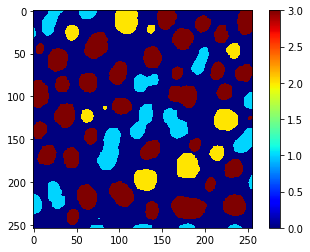

In [12]:
class_image = replace_intensities(labels, predicted_classes_with_background)
imshow(class_image, colorbar=True, colormap='jet', min_display_intensity=0)